<>:50: SyntaxWarning: invalid escape sequence '\l'
<>:56: SyntaxWarning: invalid escape sequence '\l'
<>:50: SyntaxWarning: invalid escape sequence '\l'
<>:56: SyntaxWarning: invalid escape sequence '\l'
/var/folders/c0/d4llv8t579b28n_30lmqhsv40000gn/T/ipykernel_40204/1704443763.py:50: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Posterior of $\lambda_1$")
/var/folders/c0/d4llv8t579b28n_30lmqhsv40000gn/T/ipykernel_40204/1704443763.py:56: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Posterior of $\lambda_2$")
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [tau]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 3 seconds.


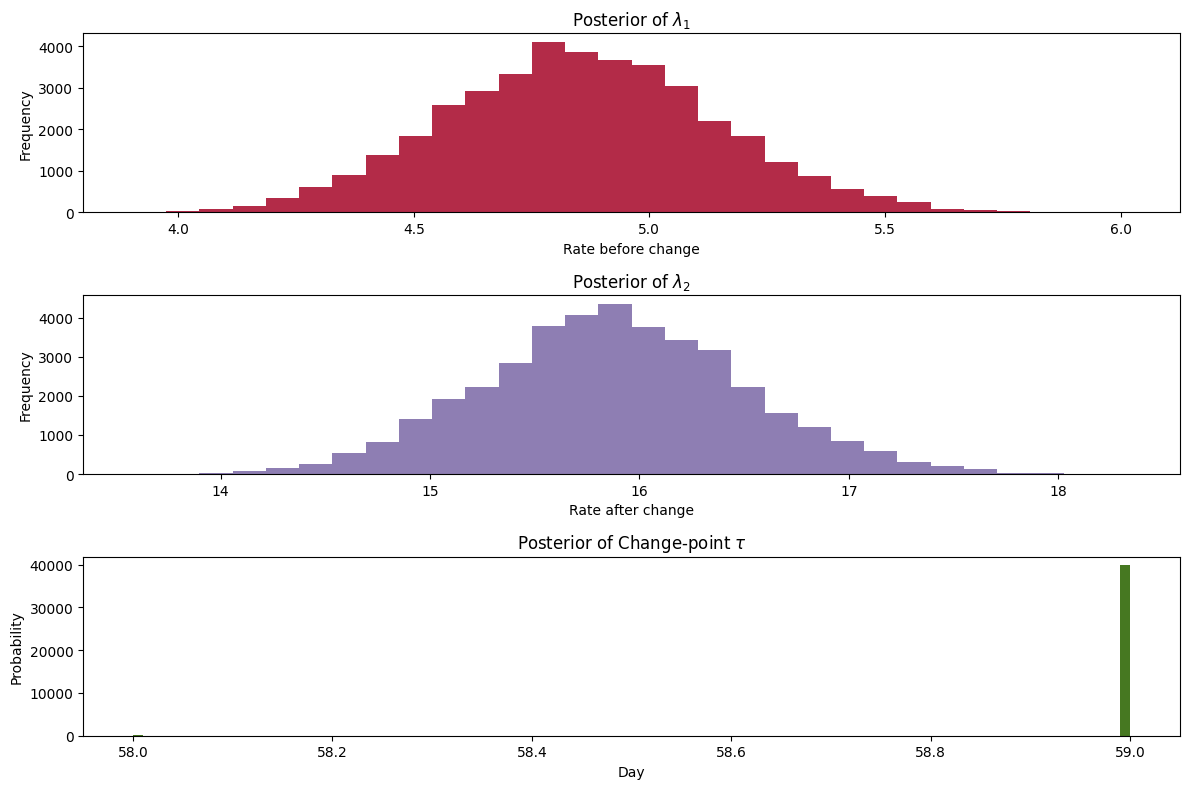

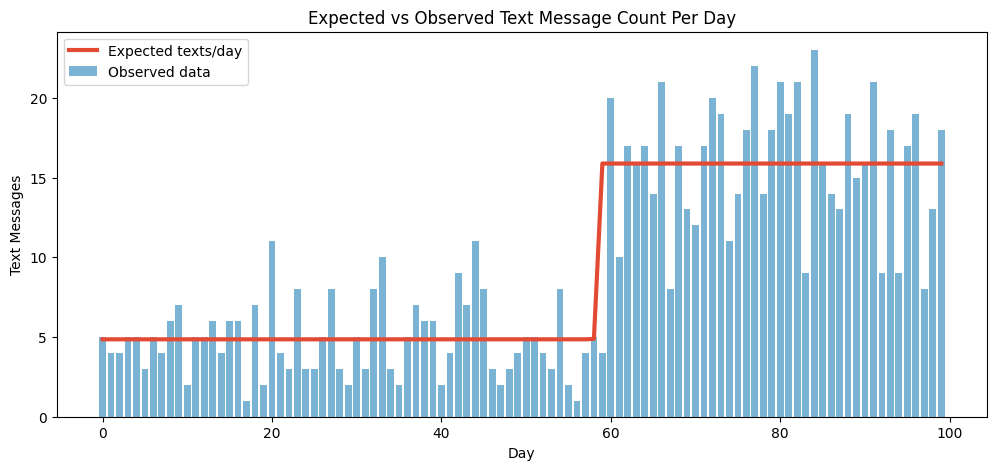

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Step 1: Simulate synthetic Poisson count data with a change-point
np.random.seed(42)
n_days = 100
tau_real = 60  # true change-point
lambda1_real = 5  # rate before change
lambda2_real = 15  # rate after change

# Generate data
data = np.concatenate([
    np.random.poisson(lambda1_real, tau_real),
    np.random.poisson(lambda2_real, n_days - tau_real)
])
n_count_data = len(data)

# Step 2: Define PyMC model
with pm.Model() as model:
    # Prior for the exponential rate parameter (lambda) based on data mean
    alpha = 1.0 / np.mean(data)

    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

    # Switchpoint model: select lambda_1 or lambda_2 based on tau
    idx = np.arange(n_count_data)
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

    # Likelihood
    observation = pm.Poisson("obs", mu=lambda_, observed=data)

# Step 3: Inference using MCMC
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

# Step 4: Extract posterior samples
lambda_1_samples = trace["lambda_1"]
lambda_2_samples = trace["lambda_2"]
tau_samples = trace["tau"]

# Step 5: Plot posterior distributions
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.hist(lambda_1_samples, bins=30, color="#A60628", alpha=0.85)
plt.title("Posterior of $\lambda_1$")
plt.xlabel("Rate before change")
plt.ylabel("Frequency")

plt.subplot(3, 1, 2)
plt.hist(lambda_2_samples, bins=30, color="#7A68A6", alpha=0.85)
plt.title("Posterior of $\lambda_2$")
plt.xlabel("Rate after change")
plt.ylabel("Frequency")

plt.subplot(3, 1, 3)
plt.hist(tau_samples, bins=n_count_data, color="#467821", rwidth=2.0)
plt.title("Posterior of Change-point $\\tau$")
plt.xlabel("Day")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()

# Step 6: Compute and plot expected text counts
expected_texts_per_day = np.zeros(n_count_data)
N = len(tau_samples)

for day in range(n_count_data):
    ix = day < tau_samples
    expected_texts_per_day[day] = (
        lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()
    ) / N

plt.figure(figsize=(12, 5))
plt.plot(range(n_count_data), expected_texts_per_day, lw=3, color="#E24A33", label="Expected texts/day")
plt.bar(np.arange(n_count_data), data, color="#348ABD", alpha=0.65, label="Observed data")
plt.title("Expected vs Observed Text Message Count Per Day")
plt.xlabel("Day")
plt.ylabel("Text Messages")
plt.legend()
plt.show()
